# UNIT 8. Decision Tres

This Unit includes main introduction to decision trees, strongly based in {cite:p}`kroese2020`.

## Cross-validation loss as a function of three depth

We start by seeing how `sklearn` builds the typical behavior of the cross-validation loss as a function of the tree depth. The cross-validation is an estimate of the expected generalization risk. Complicated trees tend to overfit the training data by producing many divisions of the feature space, as occurs with most learning methods.

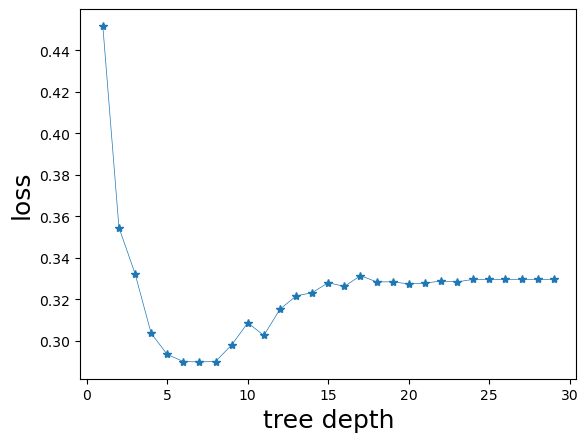

In [1]:
""" TreeDepthCV.py """
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt

def ZeroOneScore(clf, X, y):
    y_pred = clf.predict(X)
    return zero_one_loss(y, y_pred)


# Construct the training set 
X, y =  make_blobs(n_samples=5000, n_features=10, centers=3,
                           random_state=10, cluster_std=10)
    
# construct a decision tree classifier  
clf = DecisionTreeClassifier(random_state=0)

# cross validation loss as a function of tree depth (1 to 30)
xdepthlist = []
cvlist = []
tree_depth = range(1,30)
for d in tree_depth:
    xdepthlist.append(d)
    clf.max_depth=d
    cv = np.mean(cross_val_score(clf, X, y, cv=10, scoring=ZeroOneScore))
    cvlist.append(cv)
    
plt.xlabel('tree depth', fontsize=18, color='black')
plt.ylabel('loss', fontsize=18, color='black')
plt.plot(xdepthlist, cvlist,'-*' , linewidth=0.5)

## Basic step-by-step implementation

First, we import packages and define a function to generate the training and test data

In [2]:
""" BasicTree.py """
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split

def makedata():
  n_points = 500 # points
 
  X, y =  make_friedman1(n_samples=n_points, n_features=5, 
                         noise=1.0, random_state=100)
         
  return train_test_split(X, y, test_size=0.5, random_state=3)
  


now we define the main method, which calls the `makedata` method, uses the training data to build a regression tree and then predicts the responses, reporting the mean squared-error loss:

In [3]:
 
def main():
  X_train, X_test, y_train, y_test = makedata()    
  maxdepth = 10 # maximum tree depth             
  # Create tree root at depth 0                       
  treeRoot = TNode(0, X_train,y_train) 
       
  # Build the regression tree with maximal depth equal to max_depth
  Construct_Subtree(treeRoot, maxdepth) 
    
  # Predict
  y_hat = np.zeros(len(X_test))
  for i in range(len(X_test)):
     y_hat[i] = Predict(X_test[i],treeRoot)          
    
  MSE = np.mean(np.power(y_hat - y_test,2))    
  print("Basic tree: tree loss = ",  MSE)


Let us specify a tree node as a Python class. Each node has a number of attributes, including features ($X$) and the response ($y$) data, as well as the depth at which the node is placed in the tree. 

In [4]:

# tree node
class TNode:
   def __init__(self, depth, X, y): 
      self.depth = depth
      self.X = X   # matrix of explanatory variables
      self.y = y   # vector of response variables
      # initialize optimal split parameters
      self.j = None
      self.xi = None
      # initialize children to be None      
      self.left = None
      self.right = None
      # initialize the regional predictor
      self.g = None
      
   def CalculateLoss(self):
       if(len(self.y)==0):
           return 0
       
       return np.sum(np.power(self.y- self.y.mean(),2))
                    


Implementation of the training algorithm

In [5]:
  
def Construct_Subtree(node, max_depth):  
    if(node.depth == max_depth or len(node.y) == 1):
        node.g  = node.y.mean()
    else:
        j, xi = CalculateOptimalSplit(node)               
        node.j = j
        node.xi = xi
        Xt, yt, Xf, yf = DataSplit(node.X, node.y, j, xi)
              
        if(len(yt)>0):
            node.left = TNode(node.depth+1,Xt,yt)
            Construct_Subtree(node.left, max_depth)
        
        if(len(yf)>0):        
            node.right = TNode(node.depth+1, Xf,yf)
            Construct_Subtree(node.right, max_depth)      
     
    return node


to run such algorithm, we need to implement the `CalculateOptinmalSplit` function, and the `DataSplit` function in ones and zeros.

In [6]:
# split the data-set
def DataSplit(X,y,j,xi):
    ids = X[:,j]<=xi      
    Xt  = X[ids == True,:]
    Xf  = X[ids == False,:]
    yt  = y[ids == True]
    yf  = y[ids == False]
    return Xt, yt, Xf, yf             

def CalculateOptimalSplit(node):
    X = node.X
    y = node.y
    best_var = 0
    best_xi = X[0,best_var]          
    best_split_val = node.CalculateLoss()
    
    m, n  = X.shape
    
    for j in range(0,n):
        for i in range(0,m):
            xi = X[i,j]
            Xt, yt, Xf, yf = DataSplit(X,y,j,xi)
            tmpt = TNode(0, Xt, yt) 
            tmpf = TNode(0, Xf, yf) 
            loss_t = tmpt.CalculateLoss()
            loss_f = tmpf.CalculateLoss()    
            curr_val =  loss_t + loss_f
            if (curr_val < best_split_val):
                best_split_val = curr_val
                best_var = j
                best_xi = xi
    return best_var,  best_xi


Finally, we implement the recursive method for prediction

In [7]:
def Predict(X,node):
    if(node.right == None and node.left != None):
        return Predict(X,node.left)
    
    if(node.right != None and node.left == None):
        return Predict(X,node.right)
    
    if(node.right == None and node.left == None):
        return node.g
    else:
        if(X[node.j] <= node.xi):
            return Predict(X,node.left)
        else:
            return Predict(X,node.right)
    


we are now ready to run the main function providing a similar result to the `sklearn` implementation above

In [8]:
main()  # run the main program

# compare with sklearn
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = makedata()    
regTree = DecisionTreeRegressor(max_depth = 10, random_state=0)
regTree.fit(X_train,y_train)
y_hat = regTree.predict(X_test)
MSE2 = np.mean(np.power(y_hat - y_test,2))    
print("DecisionTreeRegressor: tree loss = ",  MSE2)    

Basic tree: tree loss =  9.067077996170276
DecisionTreeRegressor: tree loss =  10.19925448488538


## Bootstrap Aggregation or *bagging*

Basic bagging implementation for a regression tree, in which we compare the decision tree estimator with the corresponding bagged estimator. We use the $R^2$ metric as a comparison.

In [9]:
""" BaggingExample """
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

np.random.seed(100)

# create regression problem
n_points = 1000 # points
x, y =  make_friedman1(n_samples=n_points, n_features=15, 
                       noise=1.0, random_state=100)

# split to train/test set
x_train, x_test, y_train, y_test = \
        train_test_split(x, y, test_size=0.33, random_state=100)

# training
regTree = DecisionTreeRegressor(random_state=100)
regTree.fit(x_train,y_train)

# test
yhat = regTree.predict(x_test)

# Bagging construction
n_estimators=500
bag = np.empty((n_estimators), dtype=object)
bootstrap_ds_arr = np.empty((n_estimators), dtype=object)
for i in range(n_estimators):
    # sample bootsraped dataset
    ids = np.random.choice(range(0,len(x_train)),size=len(x_train), replace=True)

    x_boot = x_train[ids]
    y_boot = y_train[ids]
    bootstrap_ds_arr[i] = np.unique(ids)
    
    bag[i] = DecisionTreeRegressor()
    bag[i].fit(x_boot,y_boot)

# bagging prediction
yhatbag = np.zeros(len(y_test))   
for i in range(n_estimators): 
    yhatbag = yhatbag + bag[i].predict(x_test)
        
yhatbag = yhatbag/n_estimators

# out of bag loss estimation
oob_pred_arr = np.zeros(len(x_train))
for i in range(len(x_train)):
    x = x_train[i].reshape(1, -1)
    C = []
    for b in range(n_estimators):
        if(np.isin(i, bootstrap_ds_arr[b])==False):
            C.append(b)
    for pred in  bag[C]:    
        oob_pred_arr[i] = oob_pred_arr[i] + (pred.predict(x)[0]/len(C))        

L_oob = r2_score(y_train, oob_pred_arr)

print("DecisionTreeRegressor R^2 score = ",r2_score(y_test, yhat),  
      "\nBagging R^2 score = ", r2_score(y_test, yhatbag),
      "\nBagging OOB R^2 score = ",L_oob)

KeyboardInterrupt: 

```{bibliography}
:style: unsrt
```

## Random Forests

In [21]:
""" BaggingExampleRF.py """
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

# create regression problem
n_points = 1000 # points
x, y =  make_friedman1(n_samples=n_points, n_features=15, 
                       noise=1.0, random_state=100)
# split to train/test set
x_train, x_test, y_train, y_test = \
        train_test_split(x, y, test_size=0.33, random_state=100)       
rf = RandomForestRegressor(n_estimators=500, oob_score = True, max_features=8,random_state=100)
rf.fit(x_train,y_train)
yhatrf = rf.predict(x_test)

print("RF R^2 score = ", r2_score(y_test, yhatrf), 
      "\nRF OOB R^2 score = ", rf.oob_score_)


RF R^2 score =  0.8098090303200098 
RF OOB R^2 score =  0.8254263172303116


### Feature importance

Let us consider a classification problem with 15 features, only 5 of them informative.


Feature 5 (0.258110)
Feature 1 (0.229218)
Feature 2 (0.104998)
Feature 4 (0.098675)
Feature 3 (0.084086)
Feature 7 (0.026660)
Feature 11 (0.024351)
Feature 13 (0.023484)
Feature 15 (0.023372)
Feature 6 (0.022797)
Feature 8 (0.022691)
Feature 14 (0.021040)
Feature 9 (0.020687)
Feature 10 (0.020224)
Feature 12 (0.019606)


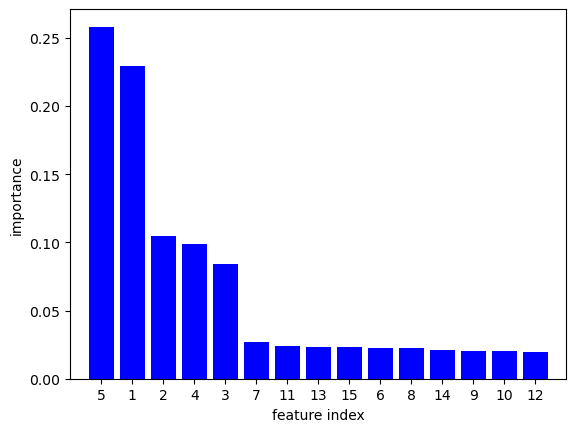

In [22]:
""" VarImportance.py """

import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt, pylab

# create regression problem
n_points = 1000 # points
x, y =  make_classification(n_samples=n_points, n_features=15, n_informative=5,
                            n_redundant=0, n_repeated=0, random_state=100, shuffle=False)

rf = RandomForestClassifier(n_estimators=200, max_features  = "log2")

rf.fit(x,y)


importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(15):
    print("Feature %d (%f)" % (indices[f]+1, importances[indices[f]]))


std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
f = plt.figure()
#plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), indices+1)
plt.xlim([-1, x.shape[1]])
pylab.xlabel("feature index")
pylab.ylabel("importance")
plt.show()
f.savefig("varimport.pdf", bbox_inches='tight')
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

### Regression boosting

Basic implementation of the regression boosting algorithm in {cite:p}`kroese2020`:
![Regression boosting](../figures/A871Kroese.png)

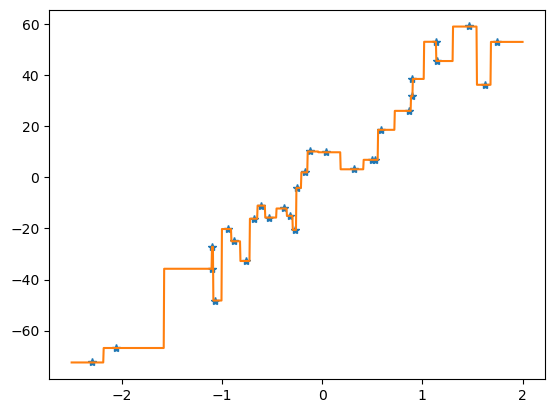

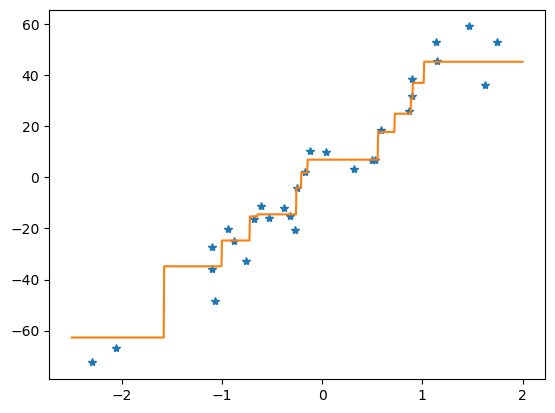

In [23]:
""" RegressionBoosting.py """
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

def TrainBoost(alpha,BoostingRounds,x,y):
    g_0 = np.mean(y)
    residuals  = y-alpha*g_0

    # list of basic regressor
    g_boost = []

    for i in range(BoostingRounds):
        h_i = DecisionTreeRegressor(max_depth=1)
        h_i.fit(x,residuals)
        residuals = residuals  - alpha*h_i.predict(x)
        g_boost.append(h_i)

    return g_0, g_boost

def Predict(g_0, g_boost,alpha, x):
    yhat = alpha*g_0*np.ones(len(x))
    for j in range(len(g_boost)):
        yhat = yhat+alpha*g_boost[j].predict(x)
    
    return yhat    


np.random.seed(1)
sz = 30

# create dataset    
x,y = make_regression(n_samples=sz, n_features=1, n_informative=1,noise=10.0)
  
# boosting algorithm
BoostingRounds = 1000
alphas = [1, 0.005]
    
for alpha in alphas:
    g_0, g_boost = TrainBoost(alpha,BoostingRounds,x,y)
    yhat = Predict(g_0, g_boost, alpha, x)
  
    # plot        
    tmpX =  np.reshape(np.linspace(-2.5,2,1000),(1000,1))
    yhatX = Predict(g_0, g_boost, alpha, tmpX)
    f = plt.figure()
    plt.plot(x,y,'*')
    plt.plot(tmpX,yhatX)
    plt.show()    

Gradient boosting algorithm:
![Gradient boosting](../figures/A872Kroese.png)

In [24]:
""" GradientBoostingRegression.py """
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# create regression problem
n_points = 1000 # points
x, y =  make_friedman1(n_samples=n_points, n_features=15, 
                       noise=1.0, random_state=100)

# split to train/test set
x_train, x_test, y_train, y_test = \
        train_test_split(x, y, test_size=0.33, random_state=100)

# boosting sklearn
from sklearn.ensemble import GradientBoostingRegressor

breg = GradientBoostingRegressor(learning_rate=0.1, 
            n_estimators=100, max_depth =3, random_state=100)
breg.fit(x_train,y_train)
yhat = breg.predict(x_test)
print("Gradient Boosting R^2 score = ",r2_score(y_test, yhat))


Gradient Boosting R^2 score =  0.8992706169055638


The AdaBoost algorithm and implementation:


![AdaBoost](../figures/A873Kroese.png)

In [25]:
""" AdaBoost.py """
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
import numpy as np


def ExponentialLoss(y,yhat):
    n = len(y)
    loss = 0
    for i in range(n):
        loss = loss+np.exp(-y[i]*yhat[i])
    loss = loss/n
    return loss

# create binary classification problem
np.random.seed(100)

n_points = 100 # points
x, y =  make_blobs(n_samples=n_points, n_features=5,  centers=2,
                      cluster_std=20.0, random_state=100)
y[y==0]=-1  

# AdaBoost implementation
BoostingRounds = 1000
n = len(x)
W = 1/n*np.ones(n)

Learner = []
alpha_b_arr = []

for i in range(BoostingRounds):
    clf = DecisionTreeClassifier(max_depth=1)
    clf.fit(x,y, sample_weight=W)
    
    Learner.append(clf)
    
    train_pred = clf.predict(x)
    err_b = 0
    for i in range(n):
        if(train_pred[i]!=y[i]):
            err_b = err_b+W[i]
    err_b = err_b/np.sum(W)
        
    alpha_b = 0.5*np.log((1-err_b)/err_b)
    
    alpha_b_arr.append(alpha_b)
    
    for i in range(n):
        W[i] = W[i]*np.exp(-y[i]*alpha_b*train_pred[i])        
    
yhat_boost = np.zeros(len(y))

for j in range(BoostingRounds):
    yhat_boost = yhat_boost+alpha_b_arr[j]*Learner[j].predict(x)
    
    
yhat = np.zeros(n)
yhat[yhat_boost>=0]=1
yhat[yhat_boost<0]=-1
print("AdaBoost Classifier exponential loss = ", ExponentialLoss(y, yhat_boost)) 
print("AdaBoost Classifier zero-one loss = ", zero_one_loss(y,yhat) ) 
     


AdaBoost Classifier exponential loss =  0.004224013663777135
AdaBoost Classifier zero-one loss =  0.0
